# 라이브러리 확인

In [1]:
import cv2
print(cv2.__version__)

4.10.0


# 드라이브 연결 및 이미지 확인 테스트

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
url = '/content/drive/MyDrive/Colab Notebooks/2024/한국표준협회/인공지능 신경망과 컴퓨터 비전 이해하기 (9월)/'

In [4]:
import matplotlib.pyplot as plt

def cv2_imshow(title, a):
    """A replacement for cv2.imshow() for use in Jupyter notebooks using Matplotlib.

    Args:
        title: str, optional. The title of the image to be displayed.
        a : np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image.
            shape (N, M, 3) is an NxM BGR color image. shape (N, M, 4) is an NxM BGRA color image.
    """
    a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    elif a.ndim == 2:
        # If it's grayscale, don't convert to RGB
        pass

    plt.imshow(a, cmap='gray' if a.ndim == 2 else None)
    if title is not None:
        plt.title(title)
    plt.axis('off')  # Hide axes for better display
    plt.show()

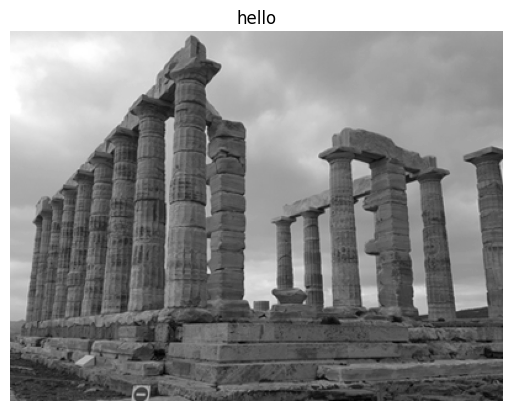

In [5]:
import cv2
import matplotlib.pyplot as plt

img_url = url + "images/hough.jpg"
image = cv2.imread(img_url, cv2.IMREAD_GRAYSCALE)
cv2_imshow("hello", image)

# 허프 변환

In [7]:
import numpy as np, cv2, time

def print_matInfo(name, image):                 # 행렬 정보 출력 함수
    if image.dtype == 'uint8':     mat_type = "CV_8U"
    elif image.dtype == 'int8':    mat_type = "CV_8S"
    elif image.dtype == 'uint16':  mat_type = "CV_16U"
    elif image.dtype == 'int16':   mat_type = "CV_16S"
    elif image.dtype == 'float32': mat_type = "CV_32F"
    elif image.dtype == 'float64': mat_type = "CV_64F"
    nchannel = 3 if image.ndim == 3 else 1

    # depth, channel 출력
    print("%12s: depth(%s), channels(%s) -> mat_type(%sC%d)"
          % (name, image.dtype, nchannel, mat_type,  nchannel))

# 수행시간 체크 함수
stime = 0
def ck_time(mode = 0 , msg = ""):
    global stime

    if (mode ==0 ):
        stime = time.perf_counter()

    elif (mode==1):
       etime = time.perf_counter()
       elapsed = (etime - stime)
       print("수행시간 = %.5f sec" % elapsed)  # 초 단위 경과 시간

    elif (mode == 2):
        etime = time.perf_counter()
        return (etime - stime)

    elif (mode== 3 ):
        etime = time.perf_counter()
        elapsed = (etime - stime)
        print("%s = %.5f sec" %(msg, elapsed))  # 초 단위 경과 시간

def time_check(func, image, size, title):                      ## 수행시간 체크 함수
	start_time = time.perf_counter()
	ret_img = func(image, size)
	elapsed = (time.perf_counter() - start_time) * 1000
	print("%s elapsed time = %0.2f ms" % (title, elapsed))
	return ret_img


# 문자열 출력 함수 - 그림자 효과
def put_string(frame, text, pt, value=None, color=(120, 200, 90)) :
    text = str(text) + str(value)
    shade = (pt[0] + 2, pt[1] + 2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame, text, shade, font, 0.7, (0, 0, 0), 2) # 그림자 효과
    cv2.putText(frame, text, pt   , font, 0.7, color, 2) # 작성 문자

def print_mat(image , name = "mat"):
    print(name)
    if len(image.shape) == 1 :
        for i in range(image.shape[0]):
            print("%2.2f " %image[i] , end='')

    elif len(image.shape) == 2 :
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                print("%s " %image[i,j], end='')
            print()

    print()

def contain(p, shape):                              # 좌표(y,x)가 범위내 인지 검사
    return 0<= p[0] < shape[0] and 0<= p[1] < shape[1]

def contain_pts(p, p1, p2):
    return p1[0] <= p[0] < p2[0] and p1[1] <= p[1] < p2[1]

# 시작점 종료점 사각형을 시작점, 크기 형식으로 변환
def rect_convert(rect):
    x0, y0, x1, y1 = rect
    pt1, pt2 = (x0, y0), (x1, y1)
    size = np.subtract(pt2, pt1)            # 두좌표 차분 - 너비 높이 계산

    return (pt1[0], pt1[1], size[0], size[1])

# 시작점과 크기로 사각형 정의
def define_rect(pt, size):
    return (pt[0], pt[1], size[0], size[1])

# 시작점 종료점으로 사각형 정의
def define_rect_pt(pt1, pt2):
    size = np.subtract(pt2, pt1)            # 두좌표 차분 - 너비 높이 계산
    return (pt1[0], pt1[1], size[0], size[1])

def accumulate(image, rho, theta):
    h, w = image.shape[:2]
    rows, cols = (h + w) * 2 // rho, int( np.pi/theta)  # 누적행렬 너비, 높이
    accumulate = np.zeros((rows, cols), np.int32)    # 직선 누적행렬

    sin_cos = [(np.sin(t * theta), np.cos(t * theta)) for t in range(cols)]  # 삼각 함수값 미리 저장
    # pts = [(y, x) for x in range(w) for y in range(h) if image[y, x] > 0 ]
    pts = np.where(image > 0)

    polars = np.dot(sin_cos, pts).T            # 행렬곱으로 허프 변환 수식 계산
    polars = (polars/ rho + rows / 2)           # 해상도 변경 및 위치 조정

    for row in polars.astype(int):
       for t, r in enumerate(row):
          accumulate[r, t] += 1                     # 좌표 누적

    return accumulate

# 허프 누적 행렬의 지역 최대값 선정
def masking(accumulate, h, w, thresh):
    rows, cols = accumulate.shape[:2]
    dst = np.zeros(accumulate.shape, np.uint32)

    for y in range(0, rows, h):             # 누적행렬 조회
        for x in range(0, cols, w):
            roi = accumulate[y:y+h, x:x+w]
            _ , max, _, (x0, y0) = cv2.minMaxLoc(roi)
            dst[y+y0, x+x0] = max
    return dst

        # 임계값 이상인 누적값(직선) 선별
def select_lines(acc_dst, rho, theta, thresh):
    rows = acc_dst.shape[0]
    r, t = np.where(acc_dst>thresh)             # 임계값 이상인 좌표(세로, 가로)

    rhos = ((r - (rows / 2)) * rho)             # rho 계산
    radians = t * theta                          # theta 계산
    value = acc_dst[r,t]                        # 임계값 이상인 누적값

    idx = np.argsort(value)[::-1]       # 누적값 기준 세로 방향 내림차순 정렬
    lines = np.transpose([rhos, radians])        # ndarray 객체 생성후 전치
    lines = lines[idx, :]                          # 누적값에 다른 정렬

    return np.expand_dims(lines, axis=1)            # 차원 확장

# 허프 변환
def houghLines(src, rho, theta, thresh):
    acc_mat = accumulate(src, rho, theta)  # 허프 누적 행렬 계산
    acc_dst = masking(acc_mat, 7, 3, thresh)  # 마스킹 처리 7행,3열
    lines   = select_lines(acc_dst, rho, theta, thresh)  # 직선 가져오기
    return lines


# 검출한 직선을 원 영상에 그리기
def draw_houghLines(src, lines, nline):
    dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)  # 컬러 영상 변환
    min_length = min(len(lines), nline)

    for i in range(min_length):
        rho, radian = lines[i, 0, 0:2]  # 수직거리 , 각도 - 3차원 행렬임
        a, b = math.cos(radian), math.sin(radian)
        pt = (a * rho, b * rho)  # 검출 직선상의 한 좌표 계산
        delta = (-1000 * b, 1000 * a)  # 직선상의 이동 위치
        pt1 = np.add(pt, delta).astype('int')
        pt2 = np.subtract(pt, delta).astype('int')
        cv2.line(dst, tuple(pt1), tuple(pt2), (0, 255, 0), 2, cv2.LINE_AA)
    return dst

## 허프 변환을 이용한 직선 검출

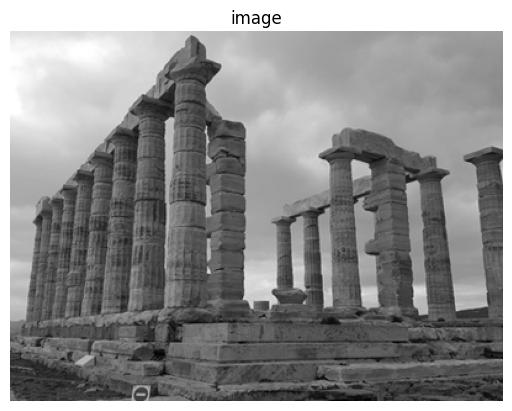

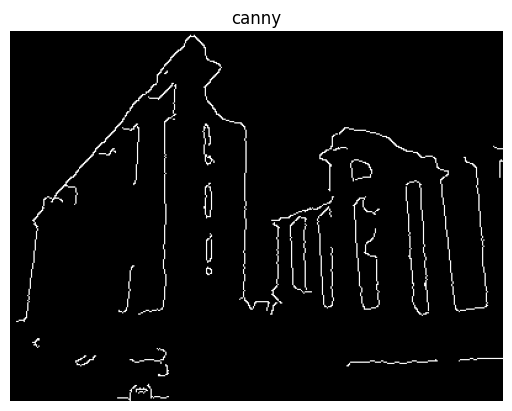

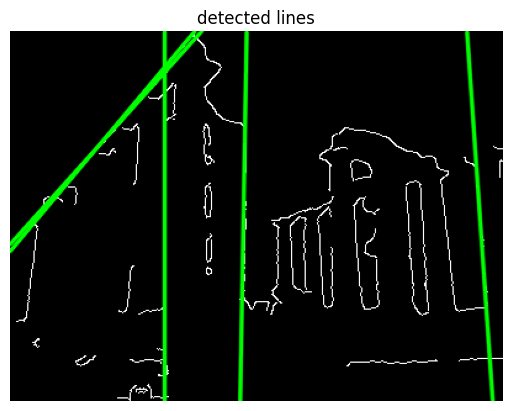

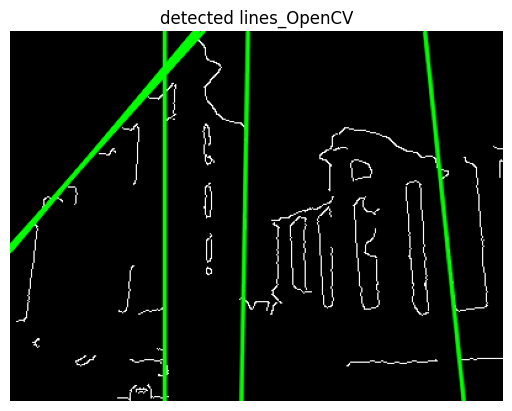

In [8]:
import numpy as np, cv2, math

def houghLines(src, rho, theta, thresh):
    acc_mat = accumulate(src, rho, theta)  # 허프 누적 행렬 계산
    acc_dst = masking(acc_mat, 7, 3, thresh)  # 마스킹 처리 7행,3열
    lines = select_lines(acc_dst, rho, theta, thresh)  # 직선 가져오기
    return lines

def draw_houghLines(src, lines, nline):
    dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)  # 컬러 영상 변환
    min_length = min(len(lines), nline)

    for i in range(min_length):
        rho, radian = lines[i, 0, 0:2]  # 수직거리 , 각도 - 3차원 행렬임
        a, b = math.cos(radian), math.sin(radian)
        pt = (a * rho, b * rho)  # 검출 직선상의 한 좌표 계산
        delta = (-1000 * b, 1000 * a)  # 직선상의 이동 위치
        pt1 = np.add(pt, delta).astype('int')
        pt2 = np.subtract(pt, delta).astype('int')
        cv2.line(dst, tuple(pt1), tuple(pt2), (0, 255, 0), 2, cv2.LINE_AA)

    return dst

image = cv2.imread(url + 'images/hough.jpg', cv2.IMREAD_GRAYSCALE)
if image is None: raise Exception("영상 파일 읽기 에러")
blur  = cv2.GaussianBlur(image, (5, 5), 2, 2)
canny = cv2.Canny(blur, 100, 200, 5)

rho, theta = 1,  np.pi / 180
lines1 = houghLines(canny, rho, theta, 80)
lines2 = cv2.HoughLines(canny, rho, theta, 80)
dst1 = draw_houghLines(canny, lines1, 7)
dst2 = draw_houghLines(canny, lines2, 7)

cv2_imshow("image", image)
cv2_imshow("canny", canny)
cv2_imshow("detected lines", dst1)
cv2_imshow("detected lines_OpenCV", dst2)

## 멀티 하네스의 전처리

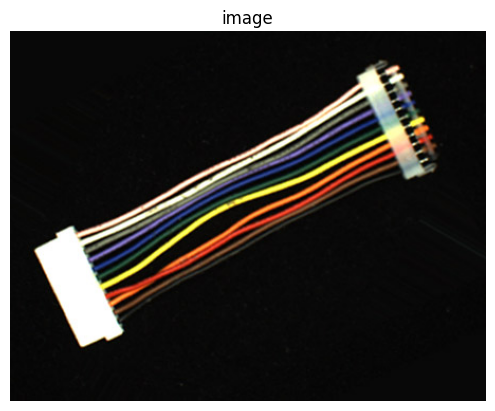

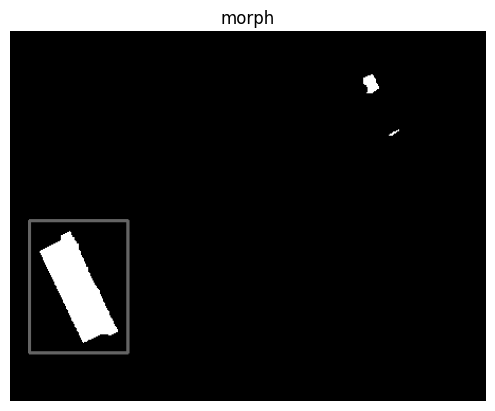

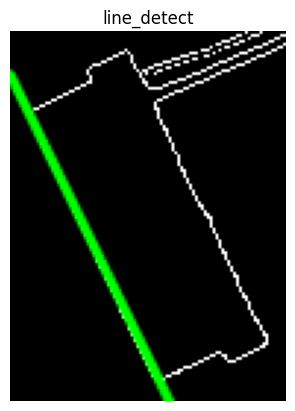

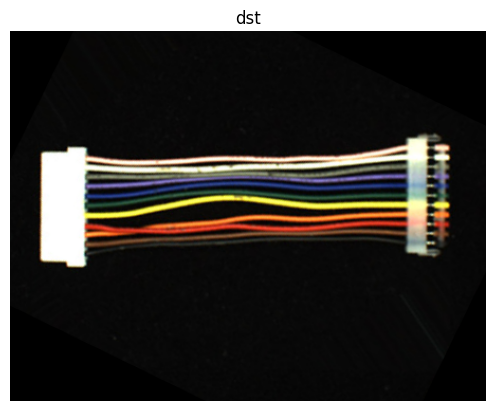

In [9]:
def detect_maxObject(img):
    # 외곽선 검출 - Opnecv 4.0부터 반환값은 2개 원소 갖는 튜플
    results = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if int(cv2.__version__[0]) >= 4:           # Opnecv 4.0은 2원소 튜플 반환
        contours = results[0]
    else:
        contours = results[1]				   # OpenCV 3.x은 3원소 튜플 반환

    areas = [cv2.contourArea(c) for c in contours]
    idx = np.argsort(areas)
    max_rect = contours[idx[-1]]

    rect = cv2.boundingRect(max_rect)        # 외곽선을 모두 포함하는 사각형 반환
    rect = np.add(rect, (-10, -10, 20, 20))   # 검출 객체 사각형 크기 확대
    return rect

image = cv2.imread(url + 'images/harness.jpg', cv2.IMREAD_COLOR)
if image is None: raise Exception("영상 파일 읽기 에러")
rho, theta = 1, np.pi / 180                             # 허프변환 거리간격, 각도간격
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)          # 명암도 영상 변환
_, th_gray = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY) # 이진 영상 변환
kernel = np.ones((3, 3), np.uint8)
morph = cv2.erode(th_gray, kernel, iterations=2)        # 침식 연산 - 2번 반복

x, y, w, h = detect_maxObject(np.copy(morph))               # 가장 큰 객체 검출
roi = th_gray[y:y+h, x:x+w]

canny = cv2.Canny(roi, 40, 100)                         # 캐니 에지 검출
lines = houghLines(canny, rho, theta, 50)               # 허프 직선 검출
# lines = cv2.HoughLines(canny, rho, theta, 50)         # OpenCV 함수

cv2.rectangle(morph, (x, y, w, h), 100, 2)                   # 큰 객체 사각형 표시
canny_line = draw_houghLines(canny, lines, 1)           # 직선 표시

angle = (np.pi - lines[0, 0, 1]) * 180 / np.pi           # 회전 각도 계산
h, w = image.shape[:2]
center = (w//2, h//2)                           # 입력 영상의 중심점
rot_map = cv2.getRotationMatrix2D(center, -angle, 1)    # 반대방향 회전 행렬 계산
dst = cv2.warpAffine(image, rot_map, (w, h), cv2.INTER_LINEAR)  # 역회전 수행

cv2_imshow("image", image)
cv2_imshow("morph", morph)
cv2_imshow("line_detect", canny_line)
# cv2.resizeWindow("line_detect", 250, canny_line.shape[0])
cv2_imshow("dst", dst)

# 해리스 코너 검출
- Local 컴퓨터에서 진행
- 파일명 : harris_detect.py
- 파일명 : harris_camera.py

# k-최근접 이웃 분류기

## 임의 좌표 생성

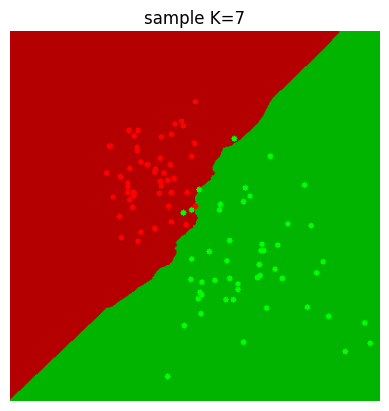

In [13]:
import numpy as np, cv2

def draw_points(image, group, color):
    for p in group:
        pt = tuple(p.astype(int))
        cv2.circle(image, pt, 3, color, cv2.FILLED)

nsample = 50
traindata = np.zeros((nsample*2, 2), np.float32)  # 학습 데이터 행렬
label = np.zeros((nsample*2, 1), np.float32)   # 레이블

cv2.randn(traindata[:nsample], 150, 30)
cv2.randn(traindata[nsample:], 250, 60)
label[:nsample], label[nsample:] = 0 , 1

K = 7
knn = cv2.ml.KNearest_create()  # kNN 클래스로 객체 생성
knn.train(traindata, cv2.ml.ROW_SAMPLE, label)  # 학습 수행

points = [(x, y) for y in range(400) for x in range(400)  ]
ret, resp, neig, dist = knn.findNearest(np.array(points, np.float32), K)  # 분류 수행

colors = [(0, 180, 0) if p==1 else  (0, 0, 180) for p in resp]
image = np.reshape(colors, (400,400,3)).astype("uint8")

draw_points(image, traindata[:nsample], color=(0, 0, 255))
draw_points(image, traindata[nsample:], color=(0, 255, 0))
cv2_imshow("sample K="+ str(K), image)

## MNIST 데이터 사용
- 자료 다운로드 : http://figshare.com/ndownloader/files/25635053

train_set= (50000, 784)
valid_set (10000, 784)
test_set (10000, 784)
training...
100개 predicting...
정확도= 98.0 %


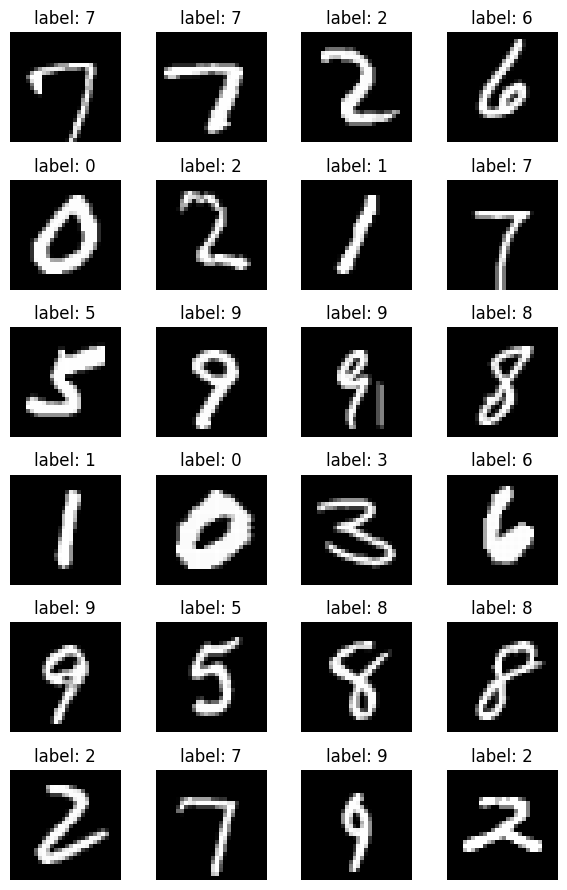

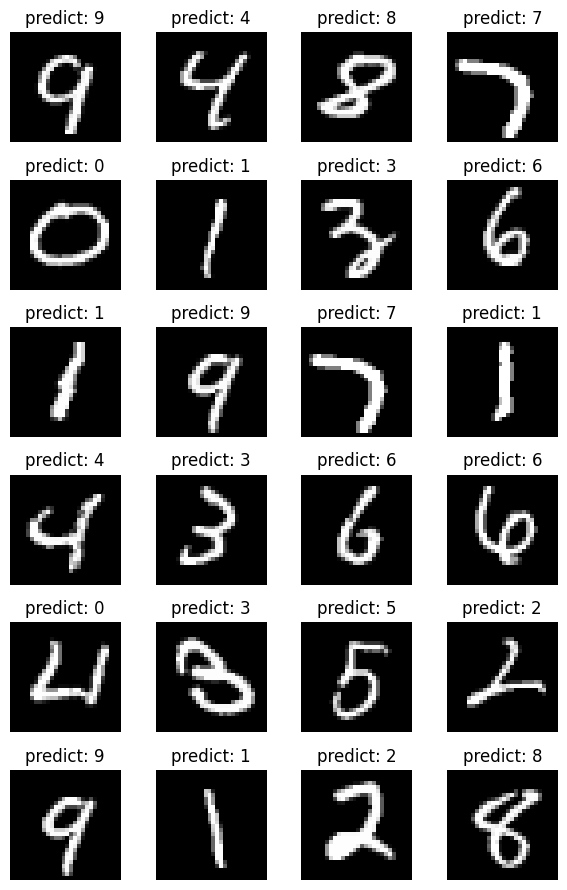

In [14]:
import cv2, numpy as np
import pickle, gzip, os
from urllib.request import urlretrieve
import matplotlib.pyplot as plt

def load_mnist(filename):
    if not os.path.exists(filename):
        print("Downloading ... " )
        link = "http://figshare.com/ndownloader/files/25635053"
        urlretrieve(link, filename)
    with gzip.open(filename, 'rb') as f:
        return pickle.load(f, encoding='latin1')

def graph_image(data, lable, title, nsample):
    plt.figure(num=title, figsize=(6, 9))
    rand_idx = np.random.choice(range(data.shape[0]), nsample)
    for i, id in enumerate(rand_idx):
        img = data[id].reshape(28, 28)
        plt.subplot(6, 4, i + 1), plt.axis('off'), plt.imshow(img, cmap='gray')
        plt.title('%s: %d' % (title , lable[id]))
    plt.tight_layout()

train_set, valid_set, test_set = load_mnist('mnist.pkl.gz')
train_data, train_label = train_set
test_data, test_label = test_set
## MNIST 로드 데이터 크기 확인
print('train_set=', train_set[0].shape)
print('valid_set', valid_set[0].shape)
print('test_set', test_set[0].shape)

print('training...')
knn = cv2.ml.KNearest_create()
knn.train(train_data, cv2.ml.ROW_SAMPLE, train_label)               # k-NN 학습 수행
#knn.save('knn.xml')

nsample = 100
print("%d개 predicting..." % nsample)
_, resp, _ , _ = knn.findNearest(test_data[:nsample], k=5)            # k-NN 분류 수행
accur = sum(resp.flat == test_label[:nsample])       # 성능 측정

print("정확도=" , accur / nsample * 100, '%')
graph_image(train_data, train_label, 'label', 24)                   # 학습 데이터 그리기
graph_image(test_data[:nsample], resp.flat, 'predict', 24)                #
plt.show()

## KNN 응용
- 학습 영상 생성
- 셀 영상 분리
- 숫자 영상 생성
  + 숫자 객체 검출
  + 숫자 객체 중앙 배치
  + 셀 영상 크기 정규화
- 모든 셀 영상 KNN 학습

### 학습 영상 생성 및 영상 분리
- get_cell() 함수 호출하면 각 영상의 영역을 셀로 구분

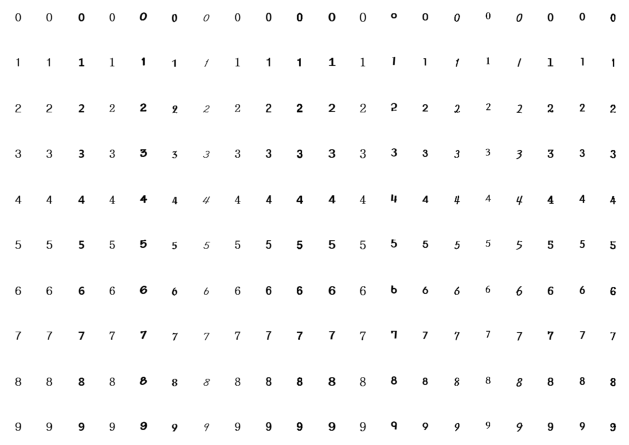

(None, None)

In [15]:
import cv2
import matplotlib.pyplot as plt

def get_cell(img, j, i, size):
    x, y = (j * size[0], i * size[1])  # 숫자칸 시작좌표
    return img[y:y + size[1], x:x + size[0]]

train_image = cv2.imread(url + 'images/train_numbers.png', cv2.IMREAD_GRAYSCALE)
if train_image is None: raise Exception("영상 파일 읽기 에러")
train_image = train_image[5:405, 6:806]                 # 상하좌우 여백 제거

size, K = (40, 40),  15                                 # 숫자 영상 크기
nclass, nsample = 10, 20                                # 그룹수, 그룹당 샘플수
cells =[get_cell(train_image, j, i, size) for i in range(nclass) for j in range(nsample)]
# cells = [np.hsplit(row, nsample) for row in np.vsplit(train_image,nclass)]
# cells = np.reshape(cells, (-1,40,40))

for i, cell in enumerate(cells):
    plt.subplot(10, 20, i+1), plt.axis('off'), plt.imshow(cell, cmap='gray')
plt.tight_layout(), plt.show()

### 숫자 객체 위치 검색 및 분리
- 숫자 객체를 셀 영역의 중앙으로 보내기
  + 숫자 객체의 위치를 찾아야 함
  + 숫자 객체의 위치 인식은 투영(projection) 히스토그램 활용

### 숫자 객체 중앙 배치 및 크기 정규화
- 숫자 객체를 셀 영역의 중앙에 위치시키겨야 함
- 핵심은 숫자 사각형의 시작 위치(start)를 찾는 것

In [16]:
import numpy as np, cv2, pickle, gzip, os
from urllib.request import urlretrieve
import matplotlib.pyplot as plt

def find_value_position(img, direct):
    project = cv2.reduce(img, direct, cv2.REDUCE_AVG).ravel()
    p0, p1 = -1, -1                                                 # 초기값
    len = project.shape[0]                                   # 전체 길이
    for i in range(len):
        if p0 < 0 and project[i] < 250: p0 = i
        if p1 < 0 and project[len-i-1] < 250 : p1 = len-i-1
    return p0, p1

# 숫자 객체 셀 중심 배치
def place_middle(number, new_size):
    h, w = number.shape[:2]
    big = max(h, w)
    square = np.full((big, big), 255, np.float32)  # 실수 자료형

    dx, dy = np.subtract(big, (w,h))//2
    square[dy:dy + h, dx:dx + w] = number
    return cv2.resize(square, new_size).flatten()  # 크기변경 및 벡터변환 후 반환


def find_number(part):
    x0, x1 = find_value_position(part, 0)  # 수직 투영
    y0, y1 = find_value_position(part, 1)  # 수평 투영
    return part[y0:y1, x0:x1]

def find_number2(part):
    contours = cv2.findContours(~part, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    rois = [cv2.boundingRect(contour) for contour in contours]
    rois = [(x, y, x+w, y+h) for x, y, w, h in rois ]   # 사각형을 시작점 종료점으로 표시

    if rois:                                # 분리된 문자 영역 누적
        pts= np.sort(rois, axis=0)             # y 방향 정렬
        x0, y0 = pts[ 0, 0:2]                  # 시작좌표 중 최소인 x, y 좌표
        x1, y1 = pts[-1, 2:]                         # 종료좌표 중 최대인 x, y 좌표
        w, h = x1-x0, y1-y0                             # 너비, 높이 계산
        part = part[y0:y0+h, x0:x0+w]
    return part

def get_cell(img, j, i, size):
    x, y = (j * size[0], i * size[1])  # 숫자칸 시작좌표
    return img[y:y + size[1], x:x + size[0]]

def load_mnist(filename):
    if not os.path.exists(filename):
        print("Downloading" )
        link = "http://deeplearning.net/data/mnist/mnist.pkl.gz"
        urlretrieve(link, filename)

    with gzip.open(filename, 'rb') as f:
        return pickle.load(f, encoding='latin1')

def graph_image(data, lable, title, nsample):
    plt.figure(num=title, figsize=(6, 9))
    rand_idx = np.random.choice(range(data.shape[0]), nsample)

    for i, id in enumerate(rand_idx):
        img = data[id].reshape((28, 28))
        plt.subplot(6, 4, i + 1), plt.axis('off'), plt.imshow(img, cmap='gray')
        plt.title(title + str(lable[id]))
    plt.tight_layout(), plt.show()

### KNN 분류기를 이용한 숫자 인식

cells 형태: (10, 20, 40, 40)
nums 형태: (200,)
trainData 형태: (200, 1600)
labels 형태: (200,)


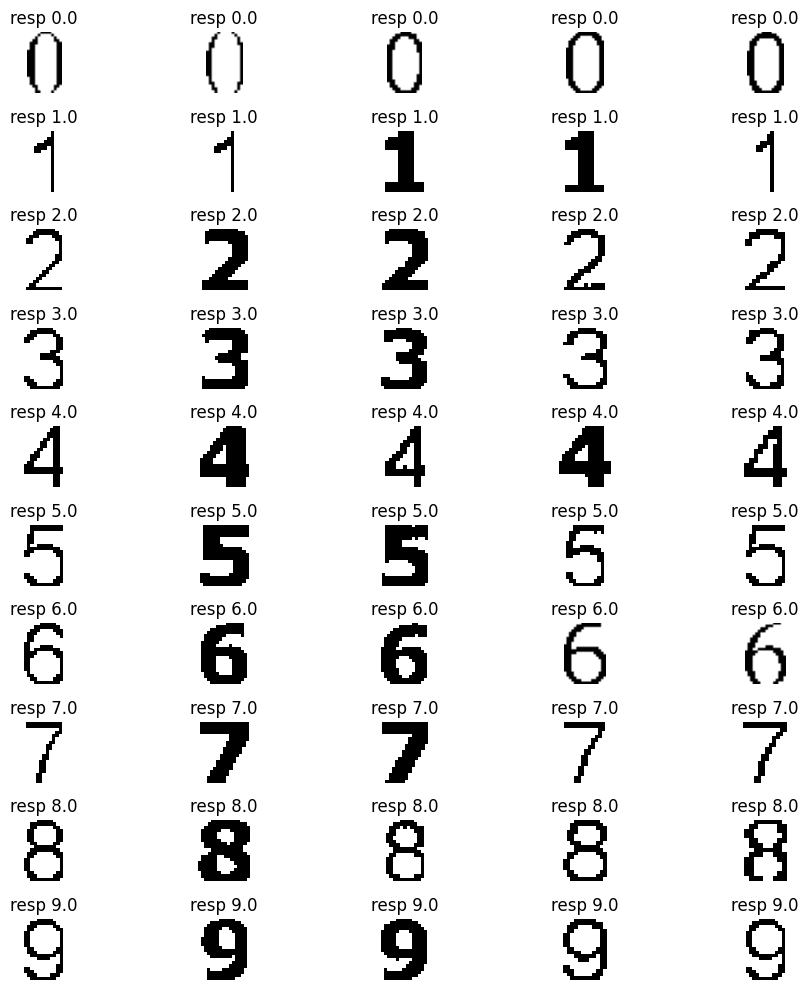

(None, None)

In [17]:
import numpy as np , cv2
import matplotlib.pyplot as plt

size, K = (40, 40),  15                                 # 숫자 영상 크기
nclass, nsample = 10, 20                                # 그룹수, 그룹당 샘플수

train_image = cv2.imread(url + 'images/train_numbers.png', cv2.IMREAD_GRAYSCALE)
if train_image is None: raise Exception("영상 파일 읽기 에러")
train_image = train_image[5:405, 6:806]
cv2.threshold(train_image, 32, 255, cv2.THRESH_BINARY, train_image)

cells = [np.hsplit(row, nsample) for row in np.vsplit(train_image, nclass)]
nums = [find_number(c) for c in np.reshape(cells, (-1, 40, 40))]
trainData = np.array([place_middle(n, size) for n in nums])
labels= np.array([ i for i in range(nclass) for j in range(nsample)], np.float32)

print('cells 형태:', np.array(cells).shape)
print('nums 형태:', np.array(nums, dtype=object).shape)
print('trainData 형태:',trainData.shape)
print('labels 형태:',labels.shape)

knn = cv2.ml.KNearest_create()
knn.train(trainData, cv2.ml.ROW_SAMPLE, labels)       # k-NN 학습 수행

plt.figure(figsize=(10,10))
for i in range(50):
    test_img = cv2.imread(url + 'images/num/%d%d.png' % (i / 5 , i % 5), cv2.IMREAD_GRAYSCALE)
    cv2.threshold(test_img, 128, 255, cv2.THRESH_BINARY, test_img)  # 이진화

    num = find_number(test_img)
    data = place_middle(num, size)  # 숫자 객체 중심 배치
    data = data.reshape(1, -1)
    _, [[resp]], _, _ = knn.findNearest(data, K)  # 숫자 분류 수행
    plt.subplot(10, 5, i+1), plt.axis('off'), plt.imshow(num, cmap='gray')
    plt.title('resp ' + str(resp))
plt.tight_layout(), plt.show()

# 영상 워핑과 영상 모핑
- 파일명 : warping_1.py
  + 마우스 드래그에 반응하는 워핑 변환
- 파일명 : warping_2_image.py
  + 카메라 렌즈 왜곡 보정